# 6imilarité group 2

### Introduction

This notebook aims to train a ResNet18 model for the task of classifying cars into ~200 different classes.

We'll begin by importing necessary libraries and setting up the GPU for training.

In [20]:
# Importing required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import zipfile
import random
import torchvision
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict

from torchcam.utils import overlay_mask

import time
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from typing import Tuple, Dict, Any, List

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda
NVIDIA A2


### Downloading the Dataset

Before we proceed, let's download the Stanford Car Dataset from Kaggle. This dataset contains images of cars categorized into classes by folders.

We'll use the Kaggle API to download the dataset directly into our notebook environment.

Please make sure you have the Kaggle API configured in your environment.

**If this is not the case:**
 - Go to your profile settings
 - Create a new token
 - Put the downloaded kaggle.json file inside /home/onyxia/.kaggle/

In [2]:
!kaggle datasets download jutrera/stanford-car-dataset-by-classes-folder

Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder
License(s): other
stanford-car-dataset-by-classes-folder.zip: Skipping, found more recently modified local copy (use --force to force download)


### Useful variables and Data Preprocessing

Before training our model, we need to preprocess the dataset. This involves creating necessary directories, unzipping the dataset, and splitting the initial test data into training and validation sets.

Let's define some helper functions for these preprocessing steps.

In [3]:
# Define paths for train, validation, and test data

DATA_PATH = "data/car_data/car_data/"
TRAIN_PATH = "data/car_data/car_data/train"
VAL_PATH = "data/car_data/car_data/val"
TEST_PATH = "data/car_data/car_data/test"

In [4]:
def create_dir(directory_path: str) -> None:
    """
    Create a directory if it doesn't exist.

    Args:
        directory_path (str): Path of the directory to be created.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

def unzip_data() -> None:
    """
    Unzip the downloaded dataset.
    """
    with zipfile.ZipFile("stanford-car-dataset-by-classes-folder.zip", "r") as zip_file:
        zip_file.extractall("data/")

def split_initial_test_folder() -> None:
    """
    Split the initial test data into training and validation data.
    """
    for class_folder in os.listdir(TEST_PATH):
        create_dir(os.path.join(VAL_PATH, class_folder))
        
        for i, image_name in enumerate(os.listdir(os.path.join(TEST_PATH, class_folder))):
            if i % 5 == 0: # Move 1/5 of data inside training dataset
                shutil.move(os.path.join(TEST_PATH, class_folder, image_name), os.path.join(TRAIN_PATH, class_folder, image_name))
            elif i % 5 < 3: # Move 2/5 of data inside validation dataset
                shutil.move(os.path.join(TEST_PATH, class_folder, image_name), os.path.join(VAL_PATH, class_folder, image_name))

### Check and Prepare Data Partition

Before proceeding with data preprocessing, let's check if the validation partition already exists. If not, we'll create necessary directories, unzip the dataset, and split the initial test data into training and validation sets.

In [5]:
if os.path.exists(VAL_PATH):
    print("Repartion already exist")
else:
    create_dir("data")
    unzip_data()
    split_initial_test_folder()

Repartion already exist


### Counting Samples and Verifying Directory Structure

We'll now count the number of samples in each partition and verify the directory structure to ensure consistency.

| Dataset            | Number of Samples | Sample Proportion |
|--------------------|-------------------|-------------------|
| Training           | 9826              | 0.61              |
| Validation         | 3262              | 0.20              |
| Test               | 3093              | 0.19              |
| Total              | 16181             | 1.00              |

In [6]:
# Count the number of samples in each partition and verify the directory structure
count_train, count_val, count_test = 0, 0, 0

for class_folder in os.listdir(TRAIN_PATH):
    count_train += len(os.listdir(os.path.join(TRAIN_PATH, class_folder)))
for class_folder in os.listdir(VAL_PATH):
    count_val += len(os.listdir(os.path.join(VAL_PATH, class_folder)))
for class_folder in os.listdir(TEST_PATH):
    count_test += len(os.listdir(os.path.join(TEST_PATH, class_folder)))

total = count_train + count_val + count_test
print(f"Training samples: {count_train}, Validation samples: {count_val}, Test samples: {count_test}, Total {total}")
print(f"Proportions => Train:{round(count_train / total, 2)}, Validation: {round(count_val / total, 2)}, Test:{round(count_test / total, 2)}")

# Assert the equality of the number of classes in each partition
assert len(os.listdir(TRAIN_PATH)) == len(os.listdir(VAL_PATH)) == len(os.listdir(TEST_PATH))

Training samples: 9826, Validation samples: 3262, Test samples: 3093, Total 16181
Proportions => Train:0.61, Validation: 0.2, Test:0.19


## Loading and displaying the data

### Visualizing Random Samples from Training Data

We'll now visualize random samples from the training data to get an idea of the images in our dataset.

In [7]:
# Util function
def truncate_string(string: str, max_length: int) -> str:
    """
    Truncate a string to a specified maximum length.

    Args:
        string (str): The string to truncate.
        max_length (int): The maximum length of the truncated string.

    Returns:
        str: The truncated string.
    """
    if len(string) > max_length:
        return string[:max_length - 3] + " [...]"
    else:
        return string

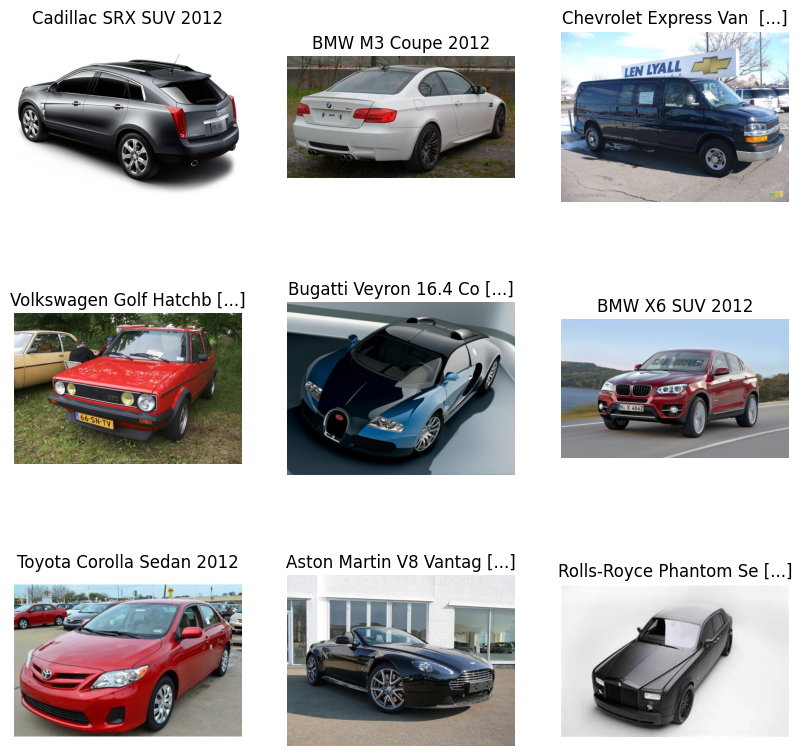

In [8]:
# Visualizing Random Samples from Training Data
plt.figure(figsize=(10, 10))
classes_directory = random.choices(os.listdir(TRAIN_PATH), k=9)

for i, class_name in enumerate(classes_directory):
    sample_filename = random.choice(os.listdir(os.path.join(TRAIN_PATH, class_name)))
    image_path = os.path.join(TRAIN_PATH, class_name, sample_filename)
    image = Image.open(image_path)
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(truncate_string(class_name, 25))
    plt.axis("off")

### Bar Chart of the class weight inside datasets

We'll now count the number of cars in each class within the training dataset and visualize the counts using a bar plot. Additionally, we'll show the mean number of samples and plot it as a horizontal line for reference.

In [9]:
car_count_dict = {}

for class_folder in os.listdir(TRAIN_PATH):
    count = len(os.listdir(os.path.join(TRAIN_PATH, class_folder)))
    car_count_dict[class_folder] = count

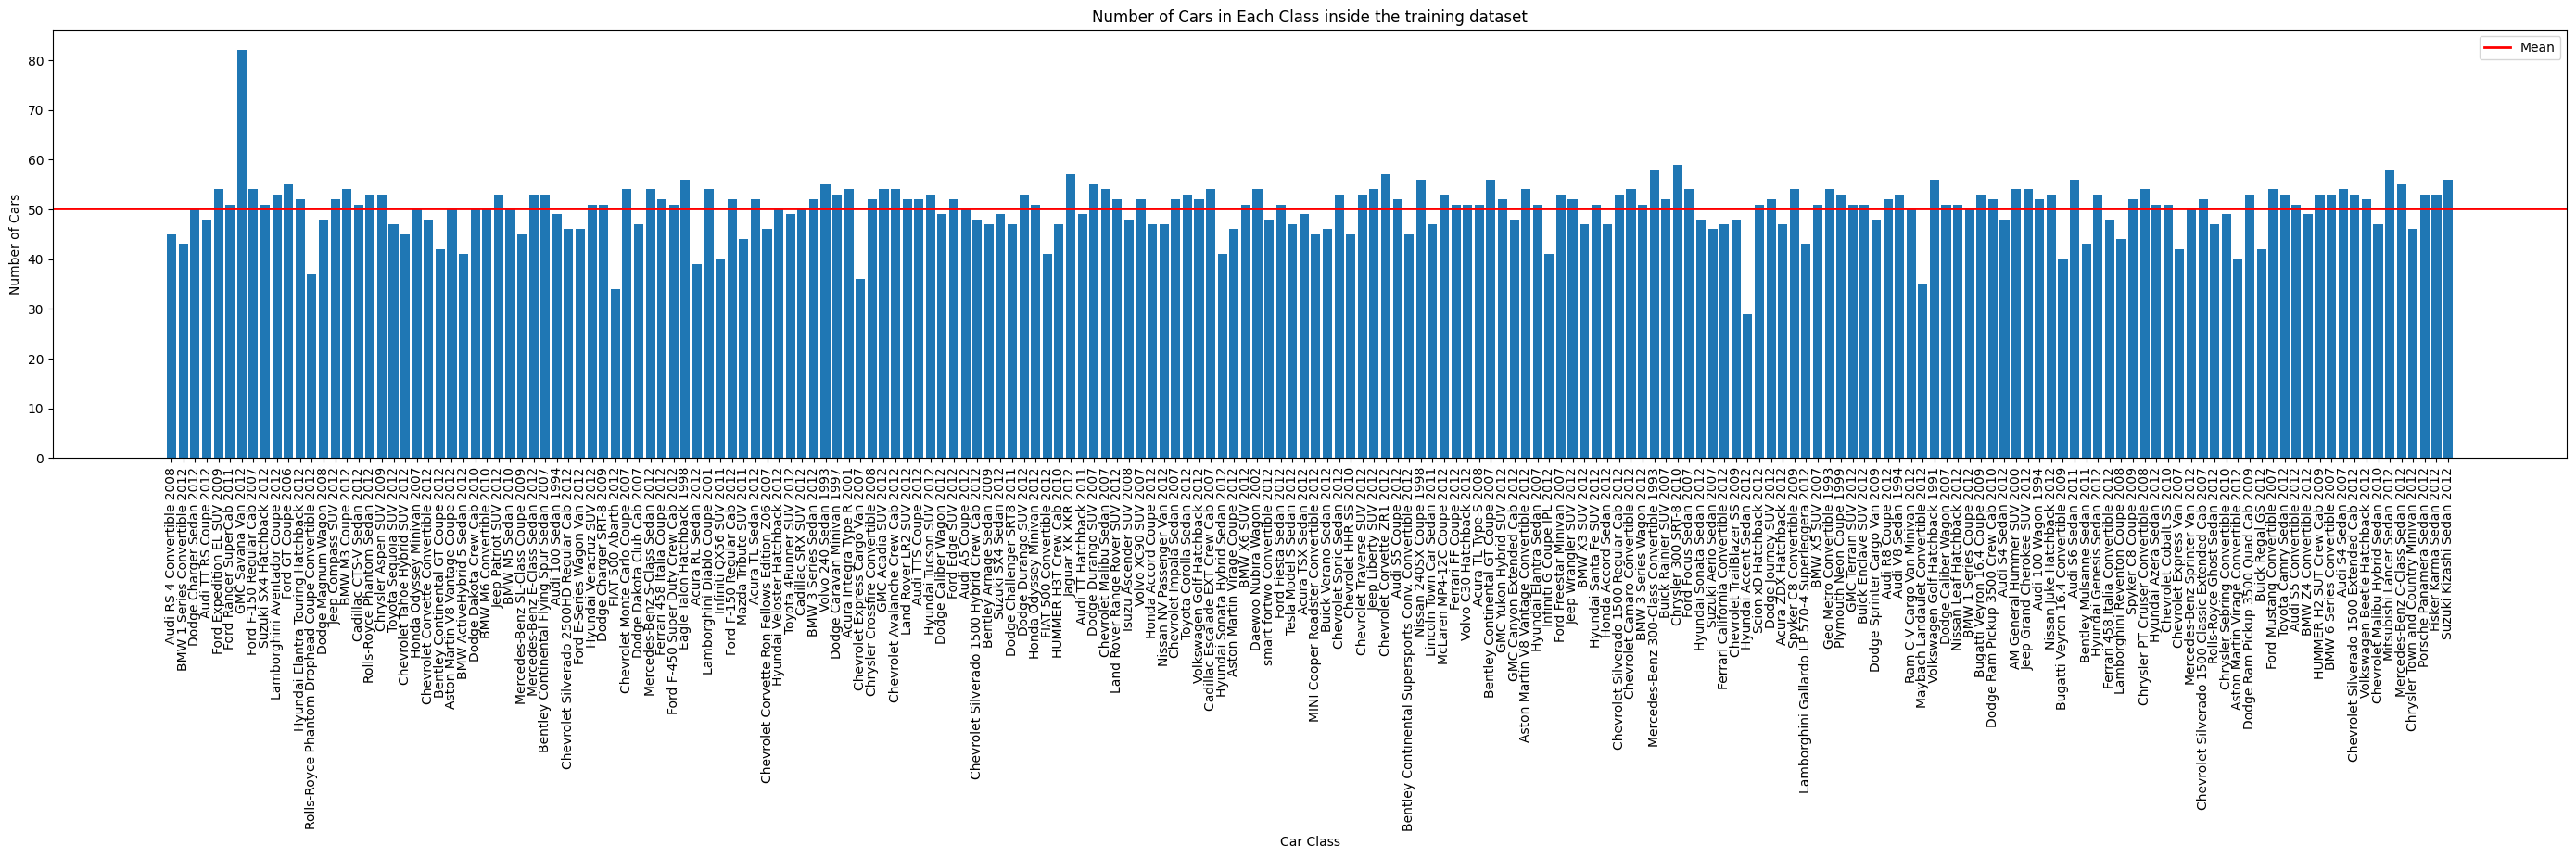

In [10]:
# Visualizing the car counts for each class
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class inside the training dataset')

# Calculating the mean of car counts
mean_value = np.mean(list(car_count_dict.values()))
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)
plt.show()

### Retrieve the consistency of the Test Dataset

Let's take a peek at the test dataset now! We'll count the number of cars in each class within the test dataset and visualize the counts using a bar plot. Ever wondered how many cars of each type are in the test set? Let's find out!

In [11]:
car_count_dict = {}

for class_folder in os.listdir(TEST_PATH):
    count = len(os.listdir(os.path.join(TEST_PATH, class_folder)))
    car_count_dict[class_folder] = count

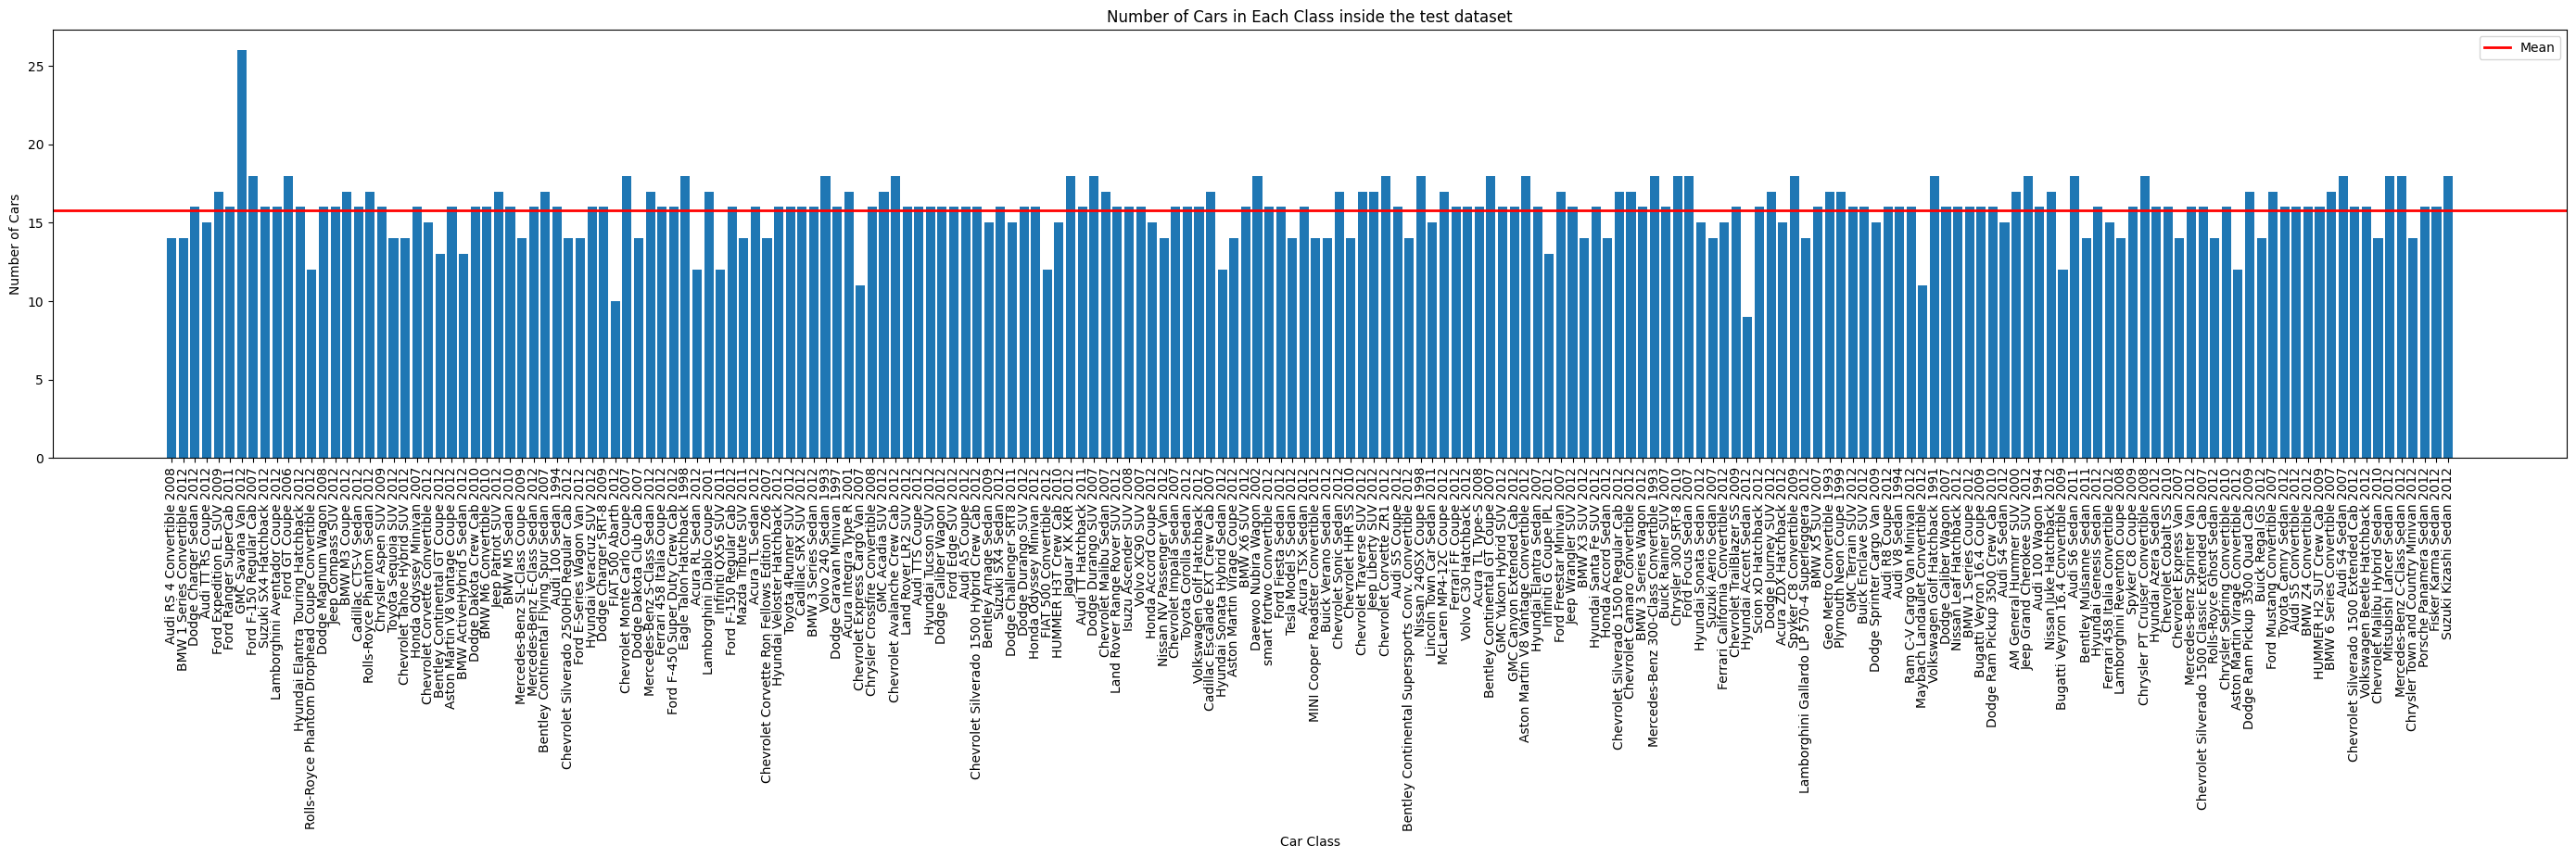

In [12]:
# Visualizing the car counts for each class in the test dataset
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class inside the test dataset')

# Calculating the mean of car counts
mean_value = np.mean(list(car_count_dict.values()))
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)
plt.show()

The distribution is pretty the same to the training dataset, 

### Preparing the Data for Model Training

It's time to whip our data into shape for training! But first, let's see how many CPU cores we have at our disposal to speed up the process.

In [14]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"{num_cores = }")

num_cores = 104


In [15]:
# Imported from ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

**Data augmentation**

With that out of the way, let's dive into transforming our dataset. We've imported some transformation tricks straight from ImageNet to ensure our data is in top-notch condition.

We'll resize our images to 224x224 pixels (in order to have a good adaptation for the ResNet18 input layer), apply some random flips and rotations to keep images unique, and sprinkle in some color jitter for good measure.

Finally, we'll convert everything into tensors and give them a good normalization using mean and standard deviation values borrowed from the mighty ImageNet. Our data will be primed and ready for our model's consumption!

In [ ]:
# defining the transformation for the dataset
train_augmentation = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

val_train_augmentation = transforms.Compose([transforms.Resize((224, 224)), #400
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_train_augmentation = transforms.Compose([transforms.Resize((224, 224)), #400
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

### Loading Data for Model Training

It's time to load up our data and get it ready for the training! We're about to create some loaders that will help us feed our data into the model efficiently. But first, let's set the stage with some batch sizes and multiprocessing magic.


In [17]:
BATCH_SIZE = 32

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_augmentation)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = num_cores)

val_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = val_train_augmentation)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = num_cores)

test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_train_augmentation)

# Create a dictionary to associate image indices with image path
image_index_to_path = defaultdict(str)
with tqdm(test_dataset) as t_ds:
    for i, (image, _) in tqdm(enumerate(t_ds)):
        image_path = test_dataset.imgs[i][0]
        image_index_to_path[i] = image_path

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers = num_cores)

100%|██████████| 3093/3093 [01:57<00:00, 26.23it/s]
3093it [01:57, 26.23it/s]


### Introducing the ResNet-18 Model!

This model comes straight from torchvision, pre-trained on ImageNet.

In [21]:
model = torchvision.models.resnet18(progress=True, pretrained=True)

num_ftrs = model.fc.in_features
no_classes = len(train_dataset.classes)

# Adapt the last dense layer for the 200 avalaible classes
model.fc = nn.Linear(num_ftrs, no_classes)

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/onyxia/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 56.0MB/s]


# Exploring Model Parameters

Let's take a peek under the hood and explore the parameters of our ResNet-18 model. These parameters hold the key to the inner workings of the model, including weights and biases of each layer.

In [22]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Compute Class weights

Let's compute the class weights based on the distribution of samples in each class.

In [23]:
# Transform string labels into int labels
counter = 0
label_to_int = {}

for class_name in os.listdir(TRAIN_PATH):
    label_to_int[class_name] = counter
    counter += 1

# Get an histogram of the classes weight
sample_to_int = []
for class_folder in os.listdir(TRAIN_PATH):
    for _ in os.listdir(os.path.join(TRAIN_PATH, class_folder)):
        sample_to_int.append(label_to_int[class_folder])

y = np.array(sample_to_int)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

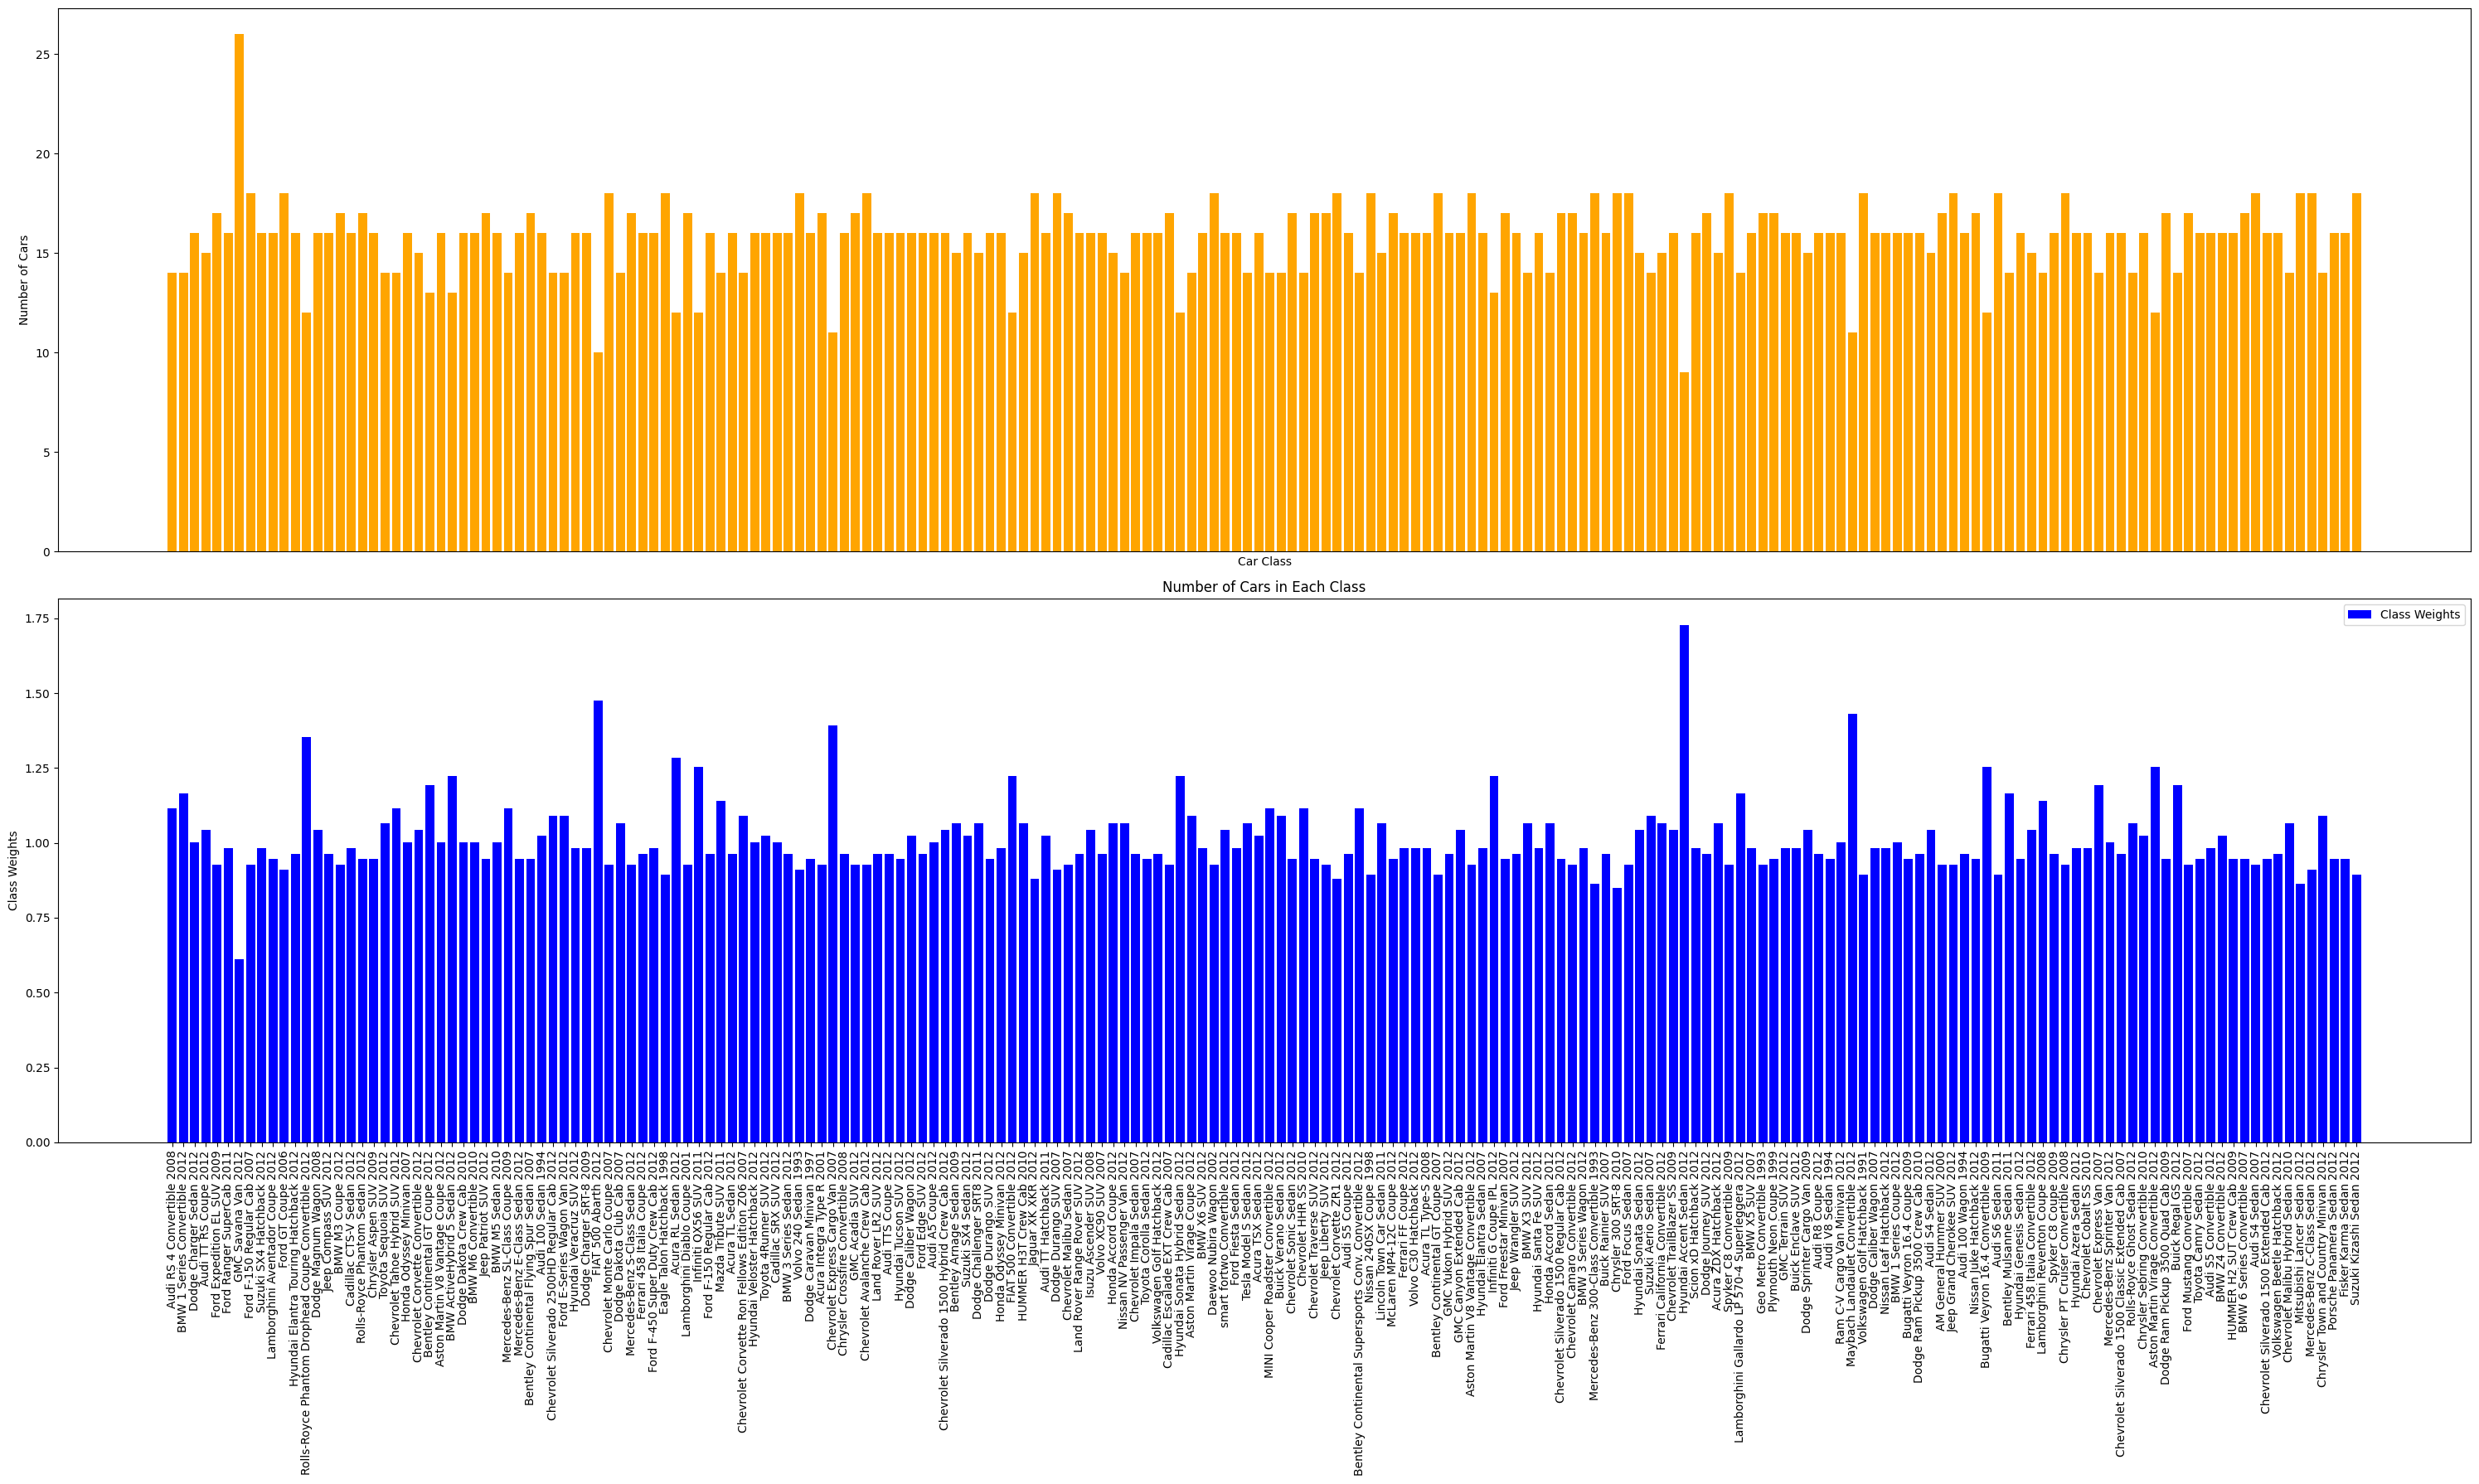

In [24]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 18))

# Plot the first bar graph on the first subplot (top)
ax1.bar(car_count_dict.keys(), car_count_dict.values(), color='orange', label='Car Count')
ax1.set_xlabel('Car Class')
ax1.set_ylabel('Number of Cars')
ax1.set_xticks([])

# Plot the second bar graph on the second subplot (bottom)
ax2.bar(car_count_dict.keys(), class_weights, color='blue', label='Class Weights')
ax2.set_ylabel('Class Weights')
ax2.set_title('Number of Cars in Each Class')
ax2.legend()

# Rotate x-axis labels for better visibility
plt.setp(ax2.get_xticklabels(), rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Setting the Hyper-Parameters and Preparing Model for Training

Let's get our model ready for training! First up, we'll move our model to the specified device (CPU or GPU). Then, we'll define our loss function and optimizer to optimize our model's performance.

In [25]:
model = model.to(device)

# Defining the loss function and the optimizer
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02)
optimizer = optim.Adam(model.parameters(), weight_decay=5e-5) # weight_decay == L2 (riddge)

In [26]:
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=3, min_lr=0.00001, verbose=True)

/opt/mamba/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


With our model on the right device and loss function and optimizer in place, we're all set to embark on our training journey. Let's unleash the power of machine learning and train our model to recognize cars!

## Training the model

# Evaluating and Training the Model

Now it's time to put our model to the test and train it! We'll define two key functions:

1. **eval_model**: This function evaluates the model's performance on the validation dataset, calculating both accuracy and loss.

2. **train_model**: Here comes the main event! This function trains our model using the training dataset, evaluating its performance on the validation dataset after each epoch. It also dynamically adjusts the learning rate based on the validation loss.

Let's dive into the code and kickstart the training process:

In [27]:
# Evaluate the model via the test dataset and generate predictions.
def eval_model(model: nn.Module, val_loader: torch.utils.data.DataLoader,
               device: torch.device) -> Tuple[float, float]:
    correct = 0.0
    total = 0.0
    running_loss = 0.0

    # Set the model to eval
    model.eval()
    
    # Forward propagation only (no training on test dataset)
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            
            # Transfer to GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward propagation
            outputs = model(images)
            
            # Get predictions from the maximum value 
            _, predicted = torch.max(outputs.data, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Total number of labels in the test data set
            total += labels.size(0)
            
            # Total correct predictions
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
    
    # Calculate the accuracy
    test_accuracy = correct / (BATCH_SIZE * len(test_loader))
    test_loss = running_loss / len(test_loader)
    return test_accuracy, test_loss

In [28]:
def train_model(model: nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader,
                criterion: nn.Module, optimizer: optim.Optimizer, scheduler: optim.lr_scheduler.ReduceLROnPlateau,
                device: torch.device, n_epochs: int = 5) -> Dict[str, List[float]]:
    
    history: Dict[str, List[float]] = {
        "losses": [],
        "accuracies": [],
        "test_accuracies": [],
        "test_losses": [],
        "lr": []
    }

    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0

        # set the model to train mode initially
        # (This is important as some models behave differently in train and test time.)
        model.train()

        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as training_epoch:
            for i, data in enumerate(training_epoch):
                inputs, labels = data

                # Transfer to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward propagation
                outputs = model(inputs)
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Calculate the loss
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                # Optimize the weights
                optimizer.step()
                
                # Calculate the loss and The accuracy
                running_loss += loss.item()
                running_correct += (labels==predicted).sum().item()
        
        # Compute and appen metric values
        epoch_acc = running_correct / (BATCH_SIZE * len(train_loader))
        epoch_loss = running_loss / len(train_loader)

        history['losses'].append(epoch_loss)
        history['accuracies'].append(epoch_acc)
                
        test_acc, test_loss = eval_model(model, val_loader, device)
        history['test_accuracies'].append(test_acc)
        history['test_losses'].append(test_loss)
        history['lr'].append(optimizer.state_dict()['param_groups'][0]['lr'])

        # Print the data
        print("Epoch %s: duration: %d s, acc: %.4f, loss: %.4f, val_acc: %.4f, val_loss: %.4f, lr: %.6f"
            % (epoch + 1, time.time() - since, epoch_acc, epoch_loss, test_acc, test_loss, history['lr'][-1])
        )
        
        # Adapt the learning rate if needed
        scheduler.step(test_loss)
        
    print('Finished Training')
    return history

In [29]:
NEPOCHS = 50

# Train the model
history = train_model(
    model,
    train_loader, 
    val_loader,
    criterion,
    optimizer,
    lrscheduler,
    device,
    n_epochs=NEPOCHS
)

Epoch 1: 100%|██████████| 308/308 [02:11<00:00,  2.34batch/s]


Epoch 1: duration: 148 s, acc: 0.0081, loss: 5.3747, val_acc: 0.0119, val_loss: 5.2242, lr: 0.001000


Epoch 2: 100%|██████████| 308/308 [01:51<00:00,  2.75batch/s]


Epoch 2: duration: 126 s, acc: 0.0159, loss: 5.0131, val_acc: 0.0100, val_loss: 7.3672, lr: 0.001000


Epoch 3: 100%|██████████| 308/308 [02:01<00:00,  2.53batch/s]


Epoch 3: duration: 138 s, acc: 0.0335, loss: 4.5818, val_acc: 0.0551, val_loss: 4.3706, lr: 0.001000


Epoch 4: 100%|██████████| 308/308 [02:12<00:00,  2.32batch/s]


Epoch 4: duration: 152 s, acc: 0.0715, loss: 4.0793, val_acc: 0.0828, val_loss: 4.2364, lr: 0.001000


Epoch 5: 100%|██████████| 308/308 [02:15<00:00,  2.27batch/s]


Epoch 5: duration: 153 s, acc: 0.1328, loss: 3.5600, val_acc: 0.1978, val_loss: 3.1999, lr: 0.001000


Epoch 6: 100%|██████████| 308/308 [02:16<00:00,  2.25batch/s]


Epoch 6: duration: 155 s, acc: 0.2265, loss: 3.0865, val_acc: 0.2481, val_loss: 2.9714, lr: 0.001000


Epoch 7: 100%|██████████| 308/308 [01:49<00:00,  2.81batch/s]


Epoch 7: duration: 124 s, acc: 0.3168, loss: 2.6745, val_acc: 0.3466, val_loss: 2.5694, lr: 0.001000


Epoch 8: 100%|██████████| 308/308 [01:44<00:00,  2.94batch/s]


Epoch 8: duration: 119 s, acc: 0.4211, loss: 2.2639, val_acc: 0.4130, val_loss: 2.3560, lr: 0.001000


Epoch 9: 100%|██████████| 308/308 [01:44<00:00,  2.94batch/s]


Epoch 9: duration: 120 s, acc: 0.4916, loss: 1.9886, val_acc: 0.4794, val_loss: 2.1135, lr: 0.001000


Epoch 10: 100%|██████████| 308/308 [01:43<00:00,  2.96batch/s]


Epoch 10: duration: 116 s, acc: 0.5688, loss: 1.7046, val_acc: 0.5483, val_loss: 1.8026, lr: 0.001000


Epoch 11: 100%|██████████| 308/308 [01:20<00:00,  3.85batch/s]


Epoch 11: duration: 92 s, acc: 0.6264, loss: 1.5131, val_acc: 0.5338, val_loss: 1.9438, lr: 0.001000


Epoch 12: 100%|██████████| 308/308 [01:18<00:00,  3.92batch/s]


Epoch 12: duration: 92 s, acc: 0.6613, loss: 1.3860, val_acc: 0.6012, val_loss: 1.6419, lr: 0.001000


Epoch 13: 100%|██████████| 308/308 [01:17<00:00,  3.97batch/s]


Epoch 13: duration: 89 s, acc: 0.7035, loss: 1.2339, val_acc: 0.6102, val_loss: 1.6128, lr: 0.001000


Epoch 14: 100%|██████████| 308/308 [01:18<00:00,  3.93batch/s]


Epoch 14: duration: 92 s, acc: 0.7304, loss: 1.1599, val_acc: 0.6279, val_loss: 1.5658, lr: 0.001000


Epoch 15: 100%|██████████| 308/308 [01:16<00:00,  4.02batch/s]


Epoch 15: duration: 89 s, acc: 0.7496, loss: 1.0950, val_acc: 0.6637, val_loss: 1.5011, lr: 0.001000


Epoch 16: 100%|██████████| 308/308 [01:16<00:00,  4.02batch/s]


Epoch 16: duration: 90 s, acc: 0.7817, loss: 0.9815, val_acc: 0.6553, val_loss: 1.4730, lr: 0.001000


Epoch 17: 100%|██████████| 308/308 [01:15<00:00,  4.06batch/s]


Epoch 17: duration: 88 s, acc: 0.7971, loss: 0.9320, val_acc: 0.6308, val_loss: 1.5788, lr: 0.001000


Epoch 18: 100%|██████████| 308/308 [01:16<00:00,  4.04batch/s]


Epoch 18: duration: 88 s, acc: 0.8195, loss: 0.8667, val_acc: 0.6888, val_loss: 1.3559, lr: 0.001000


Epoch 19: 100%|██████████| 308/308 [01:16<00:00,  4.03batch/s]


Epoch 19: duration: 88 s, acc: 0.8358, loss: 0.8283, val_acc: 0.6701, val_loss: 1.4710, lr: 0.001000


Epoch 20: 100%|██████████| 308/308 [01:16<00:00,  4.01batch/s]


Epoch 20: duration: 88 s, acc: 0.8417, loss: 0.7957, val_acc: 0.6695, val_loss: 1.4745, lr: 0.001000


Epoch 21: 100%|██████████| 308/308 [01:16<00:00,  4.02batch/s]


### Load a model

You can bring your trained model back to life for debugging purposes. Uncomment the code to use this part.

In [ ]:
# Load model architecture
#model = torch.load('save/model.pth')

# Create a new instance of the same model architecture
# For example, if you're using a custom model class:
# model = MyModelClass()

# Load the trained parameters (state_dict) into the model
#model.load_state_dict(torch.load('save/model_state_dict.pth'))

### Saving Model's Architecture and State Dictionary

To preserve our model's hard-earned knowledge, we'll save both its architecture and state dictionary:

In [ ]:
# Save model's Architecture
torch.save(model, 'save/model.pth')

# Save model's state_dict
torch.save(model.state_dict(), 'save/model_state_dict.pth')

### Visualizing Training and Validation Performance

Let's take a closer look at how our model performed during training and validation. We'll plot two key metrics over epochs:

1. **Training Loss vs. Validation Loss**: This plot helps us monitor the model's convergence and identify overfitting or underfitting.
2. **Training Accuracy vs. Validation Accuracy**: Here, we can see how well our model generalizes to unseen data compared to the training set.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(history["losses"], label="Training Losses")
axs[0].plot(history["test_losses"], label="Val Losses")
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(history["accuracies"], label="Training Accuracy")
axs[1].plot(history["test_accuracies"], label="Val Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

# Analyzing Learning Rate Evolution

Let's dive into the evolution of our model's learning rate over epochs. This plot provides crucial insights into how the learning rate changes during training, which can impact the model's convergence and performance.

In [ ]:
plt.plot(history['lr'])
plt.title("Learning rate evolution")
plt.legend(["Learning Rate"])

plt.tight_layout()
plt.show()

In [ ]:
import torch.nn.functional as F

# Set the model to evaluation mode
model.eval()

# Define empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
predicted_probs = []

# Iterate over the test dataset to make predictions
for images, labels in test_loader:
    # Transfer to GPU
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    probs, predicted = torch.max(outputs, 1)
    
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())
    predicted_probs.extend(probs.cpu().detach().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the accuracy
correct_predictions = np.sum(np.diag(conf_matrix))
total_predictions = np.sum(conf_matrix)

print("Final accuracy on the test dataset")
print(correct_predictions / total_predictions)

In [ ]:
import numpy as np

# Find incorrect predictions and their corresponding probabilities
incorrect_predictions = []
for i, (true_label, predicted_label, prob) in enumerate(zip(true_labels, predicted_labels, predicted_probs)):
    if true_label != predicted_label:
        incorrect_predictions.append((i, true_label, predicted_label, prob))

# Sort the incorrect predictions based on prediction confidence (probability)
incorrect_predictions.sort(key=lambda x: x[3])

# Get the 9 samples with the worst loss predictions
print("Samples with the worst predictions:")
input_path = []

for i in range(9):
    index, true_label, predicted_label, prob = incorrect_predictions[i]
    input_path.append(image_index_to_path[index])
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}, Probability: {prob}")

In [ ]:
activation_map = []
images_map = []
with SmoothGradCAMpp(model) as cam_extractor:
    for error_path in input_path:
        img = read_image(error_path)
        input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        input_tensor = input_tensor.to(device)
        out = model(input_tensor.unsqueeze(0))
        
        # Retrieve the CAM by passing the class index and the model output
        images_map.append(img)
        activation_map.append(cam_extractor(out.squeeze(0).argmax().item(), out))

In [ ]:
# Display each image on a subplot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, (img, act_map) in enumerate(zip(images_map, activation_map)):
    result = overlay_mask(to_pil_image(img), to_pil_image(act_map[0].squeeze(0), mode='F'), alpha=0.5)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(result)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define the class labels
class_labels = [str(i) for i in range(len(conf_matrix))]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(50, 50))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

In [ ]:
# Compute the classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)